# *Neural Network (MLP)*
## *Training a multilayer percetron to handle image classification using the CIFAR10 dataset with Keras.*

In [1]:
# set seed for reproducibility purposes.
from numpy.random import seed
seed(888)
from tensorflow.random import set_seed
set_seed(404)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from time import strftime

import tensorflow as tf
import keras

from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

from keras.preprocessing.image import array_to_img
from IPython.display import display

from keras.callbacks import TensorBoard

%matplotlib inline

In [3]:
# CONSTANTS

# cifar-10 classes
LABEL_NAMES = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
            'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
IMG_WIDTH = 32
IMG_HEIGHT = 32
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMG_WIDTH * IMG_HEIGHT * COLOR_CHANNELS

# "... There are 50000 training images and 10000 test images."
TOTAL_TRAINING_SIZE = 50000
TEST_SIZE = 10000
VALIDATION_SIZE = int(TOTAL_TRAINING_SIZE * 0.2)
TRAIN_SIZE = TOTAL_TRAINING_SIZE - VALIDATION_SIZE
SMALL_TRAIN_SIZE = 1000

# tensorboard
LOG_DIR = 'tensorboard_logs/'

### *Get the data:*
#### https://www.cs.toronto.edu/~kriz/cifar.html
#### https://keras.io/api/datasets/cifar10/

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

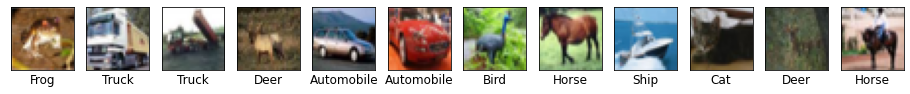

In [5]:
plt.figure(figsize=(16, 8))

# display some loaded images
for i in range(12):
    plt.subplot(1, 12, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(LABEL_NAMES[y_train[i][0]], fontsize=12)
    plt.imshow(x_train[i])

---

### *Preprocessing Data*

In [6]:
num_img, w, h, c = x_train.shape
print(f'Images: {num_img} \t| Width: {w} \t| Height: {h} \t| Channels: {c}')

Images: 50000 	| Width: 32 	| Height: 32 	| Channels: 3


In [7]:
%%time
# scale color values down 0-1 (makes it easier to calculate the loss and adjust weigths)
x_train, x_test = x_train / 255.0, x_test / 255.0

# flatten dataset out
x_train = x_train.reshape(len(x_train), TOTAL_INPUTS)
x_test = x_test.reshape(len(x_test), TOTAL_INPUTS)

print(f'x_train shape: {x_train.shape}')
print(f'x_test shape: {x_test.shape}')

x_train shape: (50000, 3072)
x_test shape: (10000, 3072)
CPU times: user 1.09 s, sys: 4.1 s, total: 5.19 s
Wall time: 15.2 s


---

### *Split the training datasets into Training and Validation*

In [8]:
x_validate = x_train[:VALIDATION_SIZE]
y_validate = y_train[:VALIDATION_SIZE]
print('Validation shape: ', x_validate.shape)

x_train_final = x_train[VALIDATION_SIZE:]
y_train_final = y_train[VALIDATION_SIZE:]
print('Training shape: ', x_train_final.shape)

Validation shape:  (10000, 3072)
Training shape:  (40000, 3072)


In [9]:
# separate a small dataset to check how the computer handles it
x_train_sm = x_train[:SMALL_TRAIN_SIZE]
y_train_sm = y_train[:SMALL_TRAIN_SIZE]
print('Small training shape: ', x_train_sm.shape)

Small training shape:  (1000, 3072)


---

### *Define and Compile the Neural Network using Keras*

In [10]:
# https://keras.io/api/layers/core_layers/dense/
# https://keras.io/guides/sequential_model/
model_1 = Sequential([
    # 1st hidden layer
    Dense(units=128, input_dim=TOTAL_INPUTS, activation='relu', name='m1_hidden1'),
    # 2nd hidden layer
    Dense(units=64, activation='relu', name='m1_hidden2'),
    # 3rd hidden layer
    Dense(units=16, activation='relu', name='m1_hidden3'), 
    # output layer
    Dense(units=10, activation='softmax', name='m1_output')
])

# https://keras.io/api/optimizers/
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [11]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
m1_hidden1 (Dense)           (None, 128)               393344    
_________________________________________________________________
m1_hidden2 (Dense)           (None, 64)                8256      
_________________________________________________________________
m1_hidden3 (Dense)           (None, 16)                1040      
_________________________________________________________________
m1_output (Dense)            (None, 10)                170       
Total params: 402,810
Trainable params: 402,810
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Making sense of the number of params in each layer
hidden1_total = 393344 # number of parameters
hidden1_units = 128
connections = TOTAL_INPUTS * hidden1_units
print('Number of connections: ', connections)
# the missing parameters (128 total) are the bias for each neuron
print('Number of bias:', hidden1_total - connections)

Number of connections:  393216
Number of bias: 128


---

### *Tensorboard*
### *(Visualize learning)*

In [13]:
def get_tensorboard(model_name):
    folder_name = f'{model_name} - {strftime("%H %M")}'
    dir_paths = os.path.join(LOG_DIR, folder_name)

    try:
        os.makedirs(dir_paths)
    except OSError as err:
        print(err.strerror)
    else:
        print('Successfully created directory.')
        
    return TensorBoard(log_dir=dir_paths)

### *Fit the model*
#### https://keras.io/api/models/model_training_apis/

In [14]:
samples_per_batch = 500
len(x_train_sm)

1000

In [15]:
%%time
num_epochs = 150
# run the fit method in with the small dataset to have an idea about how it will work
model_1.fit(x_train_sm, y_train_sm,
            callbacks=[get_tensorboard("model_1_sm")],
            epochs=num_epochs, batch_size=samples_per_batch,
            validation_data=(x_validate, y_validate)
           )
# Wall time: 47.6 s

Successfully created directory.
Epoch 1/150
1/2 [==============>...............] - ETA: 0s - loss: 2.4055 - accuracy: 0.0760WARNING:tensorflow:From /home/edlcorrea/miniconda3/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
2/2 [==============================] - 1s 487ms/step - loss: 2.4855 - accuracy: 0.0810 - val_loss: 2.7289 - val_accuracy: 0.1001
Epoch 2/150
2/2 [==============================] - 0s 117ms/step - loss: 2.5303 - accuracy: 0.1290 - val_loss: 2.3546 - val_accuracy: 0.1111
Epoch 3/150
2/2 [==============================] - 0s 114ms/step - loss: 2.3344 - accuracy: 0.1320 - val_loss: 2.3032 - val_accuracy: 0.1122
Epoch 4/150
2/2 [==============================] - 0s 114ms/step - loss: 2.3077 - accuracy: 0.1280 - val_loss: 2.2938 - val_accuracy: 0.1483
Epoch 5/150
2/2 [=============

2/2 [==============================] - 0s 109ms/step - loss: 2.0074 - accuracy: 0.2650 - val_loss: 2.1184 - val_accuracy: 0.2270
Epoch 55/150
2/2 [==============================] - 0s 112ms/step - loss: 1.9894 - accuracy: 0.2780 - val_loss: 2.1196 - val_accuracy: 0.2326
Epoch 56/150
2/2 [==============================] - 0s 116ms/step - loss: 1.9761 - accuracy: 0.2910 - val_loss: 2.1272 - val_accuracy: 0.2347
Epoch 57/150
2/2 [==============================] - 0s 106ms/step - loss: 1.9803 - accuracy: 0.2970 - val_loss: 2.1386 - val_accuracy: 0.2259
Epoch 58/150
2/2 [==============================] - 0s 124ms/step - loss: 1.9803 - accuracy: 0.2920 - val_loss: 2.1095 - val_accuracy: 0.2385
Epoch 59/150
2/2 [==============================] - 0s 103ms/step - loss: 1.9606 - accuracy: 0.2990 - val_loss: 2.1128 - val_accuracy: 0.2346
Epoch 60/150
2/2 [==============================] - 0s 102ms/step - loss: 1.9416 - accuracy: 0.2980 - val_loss: 2.1032 - val_accuracy: 0.2382
Epoch 61/150
2/2 [=

Epoch 112/150
2/2 [==============================] - 0s 108ms/step - loss: 1.6031 - accuracy: 0.4200 - val_loss: 2.0553 - val_accuracy: 0.2802
Epoch 113/150
2/2 [==============================] - 0s 110ms/step - loss: 1.6050 - accuracy: 0.4180 - val_loss: 2.0273 - val_accuracy: 0.2751
Epoch 114/150
2/2 [==============================] - 0s 112ms/step - loss: 1.6204 - accuracy: 0.4050 - val_loss: 2.0102 - val_accuracy: 0.2850
Epoch 115/150
2/2 [==============================] - 0s 105ms/step - loss: 1.5989 - accuracy: 0.4160 - val_loss: 1.9933 - val_accuracy: 0.2841
Epoch 116/150
2/2 [==============================] - 0s 108ms/step - loss: 1.5964 - accuracy: 0.4180 - val_loss: 2.0136 - val_accuracy: 0.2839
Epoch 117/150
2/2 [==============================] - 0s 108ms/step - loss: 1.5920 - accuracy: 0.4170 - val_loss: 2.0276 - val_accuracy: 0.2781
Epoch 118/150
2/2 [==============================] - 0s 82ms/step - loss: 1.6175 - accuracy: 0.4070 - val_loss: 1.9987 - val_accuracy: 0.2874


##### *The fit method above was run 3x in sequence, the accuracy related to the training data kept improving but the accuracy related to the validation data had no improvements after the first run. (This test was done to visualize with Tensorboard)*
---

In [16]:
# create a second model to compare learning using regularization techniques
model_2 = Sequential()
# this dropout layer acts like the first layer so it needs to receive the information about the input
model_2.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_2.add(Dense(units=128, activation='relu', name='m2_hidden1'))
model_2.add(Dense(64, activation='relu', name='m2_hidden2'))
model_2.add(Dense(16, activation='relu', name='m2_hidden3'))
model_2.add(Dense(10, activation='softmax', name='m2_output'))

model_2.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [17]:
%%time
num_epochs = 150

model_2.fit(x_train_sm, y_train_sm,
            callbacks=[get_tensorboard("model_2_sm")],
            epochs=num_epochs, batch_size=samples_per_batch,
            validation_data=(x_validate, y_validate)
           )
# Wall time: 55.8 s

Successfully created directory.
Epoch 1/150
2/2 [==============================] - 1s 273ms/step - loss: 2.3952 - accuracy: 0.1220 - val_loss: 2.4114 - val_accuracy: 0.1022
Epoch 2/150
2/2 [==============================] - 0s 118ms/step - loss: 2.4342 - accuracy: 0.1140 - val_loss: 2.3808 - val_accuracy: 0.1027
Epoch 3/150
2/2 [==============================] - 0s 115ms/step - loss: 2.3791 - accuracy: 0.1250 - val_loss: 2.3414 - val_accuracy: 0.1259
Epoch 4/150
2/2 [==============================] - 0s 98ms/step - loss: 2.3057 - accuracy: 0.1500 - val_loss: 2.2984 - val_accuracy: 0.1425
Epoch 5/150
2/2 [==============================] - 0s 91ms/step - loss: 2.2879 - accuracy: 0.1350 - val_loss: 2.2650 - val_accuracy: 0.1478
Epoch 6/150
2/2 [==============================] - 0s 120ms/step - loss: 2.2592 - accuracy: 0.1420 - val_loss: 2.2818 - val_accuracy: 0.1285
Epoch 7/150
2/2 [==============================] - 0s 120ms/step - loss: 2.2491 - accuracy: 0.1490 - val_loss: 2.2485 - val_

2/2 [==============================] - 0s 86ms/step - loss: 1.7537 - accuracy: 0.3750 - val_loss: 2.0032 - val_accuracy: 0.2856
Epoch 59/150
2/2 [==============================] - 0s 112ms/step - loss: 1.7310 - accuracy: 0.3680 - val_loss: 2.0061 - val_accuracy: 0.2891
Epoch 60/150
2/2 [==============================] - 0s 107ms/step - loss: 1.7247 - accuracy: 0.3840 - val_loss: 2.0118 - val_accuracy: 0.2900
Epoch 61/150
2/2 [==============================] - 0s 107ms/step - loss: 1.7087 - accuracy: 0.3890 - val_loss: 1.9588 - val_accuracy: 0.3105
Epoch 62/150
2/2 [==============================] - 0s 113ms/step - loss: 1.6820 - accuracy: 0.4070 - val_loss: 1.9885 - val_accuracy: 0.2950
Epoch 63/150
2/2 [==============================] - 0s 114ms/step - loss: 1.6851 - accuracy: 0.3930 - val_loss: 1.9446 - val_accuracy: 0.3253
Epoch 64/150
2/2 [==============================] - 0s 111ms/step - loss: 1.6661 - accuracy: 0.4140 - val_loss: 1.9560 - val_accuracy: 0.3088
Epoch 65/150
2/2 [==

Epoch 116/150
2/2 [==============================] - 0s 109ms/step - loss: 1.2650 - accuracy: 0.5860 - val_loss: 1.9011 - val_accuracy: 0.3638
Epoch 117/150
2/2 [==============================] - 0s 111ms/step - loss: 1.2891 - accuracy: 0.5570 - val_loss: 1.9195 - val_accuracy: 0.3596
Epoch 118/150
2/2 [==============================] - 0s 125ms/step - loss: 1.2664 - accuracy: 0.5710 - val_loss: 1.9043 - val_accuracy: 0.3611
Epoch 119/150
2/2 [==============================] - 0s 113ms/step - loss: 1.2397 - accuracy: 0.5960 - val_loss: 1.9299 - val_accuracy: 0.3648
Epoch 120/150
2/2 [==============================] - 0s 111ms/step - loss: 1.2571 - accuracy: 0.5760 - val_loss: 1.9090 - val_accuracy: 0.3680
Epoch 121/150
2/2 [==============================] - 0s 101ms/step - loss: 1.2435 - accuracy: 0.5850 - val_loss: 1.9107 - val_accuracy: 0.3621
Epoch 122/150
2/2 [==============================] - 0s 85ms/step - loss: 1.2617 - accuracy: 0.5740 - val_loss: 1.9064 - val_accuracy: 0.3668


In [18]:
# third model
model_3 = Sequential()
model_3.add(Dropout(0.2, seed=42, input_shape=(TOTAL_INPUTS,)))
model_3.add(Dense(units=128, activation='relu', name='m2_hidden1'))
model_3.add(Dropout(0.25, seed=42))
model_3.add(Dense(64, activation='relu', name='m2_hidden2'))
model_3.add(Dense(16, activation='relu', name='m2_hidden3'))
model_3.add(Dense(10, activation='softmax', name='m2_output'))

model_3.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [19]:
%%time
num_epochs = 150

model_3.fit(x_train_sm, y_train_sm,
            callbacks=[get_tensorboard("model_3_sm")],
            epochs=num_epochs, batch_size=samples_per_batch,
            validation_data=(x_validate, y_validate)
           )
# Wall time: 1min 1s

Successfully created directory.
Epoch 1/150
2/2 [==============================] - 0s 247ms/step - loss: 2.4274 - accuracy: 0.1140 - val_loss: 2.3229 - val_accuracy: 0.1110
Epoch 2/150
2/2 [==============================] - 0s 112ms/step - loss: 2.3539 - accuracy: 0.0990 - val_loss: 2.3000 - val_accuracy: 0.1128
Epoch 3/150
2/2 [==============================] - 0s 110ms/step - loss: 2.3146 - accuracy: 0.0960 - val_loss: 2.3011 - val_accuracy: 0.1046
Epoch 4/150
2/2 [==============================] - 0s 113ms/step - loss: 2.3211 - accuracy: 0.1140 - val_loss: 2.2787 - val_accuracy: 0.1410
Epoch 5/150
2/2 [==============================] - 0s 137ms/step - loss: 2.3008 - accuracy: 0.1310 - val_loss: 2.2787 - val_accuracy: 0.1652
Epoch 6/150
2/2 [==============================] - 0s 110ms/step - loss: 2.2962 - accuracy: 0.1260 - val_loss: 2.2867 - val_accuracy: 0.1333
Epoch 7/150
2/2 [==============================] - 0s 103ms/step - loss: 2.2892 - accuracy: 0.1320 - val_loss: 2.2766 - va

2/2 [==============================] - 0s 112ms/step - loss: 1.8537 - accuracy: 0.3260 - val_loss: 1.9279 - val_accuracy: 0.3070
Epoch 59/150
2/2 [==============================] - 0s 112ms/step - loss: 1.8440 - accuracy: 0.3290 - val_loss: 1.9374 - val_accuracy: 0.2962
Epoch 60/150
2/2 [==============================] - 0s 113ms/step - loss: 1.8442 - accuracy: 0.3340 - val_loss: 1.9347 - val_accuracy: 0.3099
Epoch 61/150
2/2 [==============================] - 0s 89ms/step - loss: 1.8275 - accuracy: 0.3380 - val_loss: 1.9196 - val_accuracy: 0.3187
Epoch 62/150
2/2 [==============================] - 0s 98ms/step - loss: 1.7917 - accuracy: 0.3650 - val_loss: 1.9120 - val_accuracy: 0.3138
Epoch 63/150
2/2 [==============================] - 0s 123ms/step - loss: 1.7786 - accuracy: 0.3540 - val_loss: 1.9076 - val_accuracy: 0.3137
Epoch 64/150
2/2 [==============================] - 0s 109ms/step - loss: 1.7726 - accuracy: 0.3730 - val_loss: 1.8974 - val_accuracy: 0.3197
Epoch 65/150
2/2 [===

Epoch 116/150
2/2 [==============================] - 0s 108ms/step - loss: 1.3759 - accuracy: 0.5290 - val_loss: 1.8361 - val_accuracy: 0.3616
Epoch 117/150
2/2 [==============================] - 0s 85ms/step - loss: 1.4094 - accuracy: 0.4980 - val_loss: 1.8358 - val_accuracy: 0.3605
Epoch 118/150
2/2 [==============================] - 0s 106ms/step - loss: 1.3660 - accuracy: 0.5250 - val_loss: 1.8441 - val_accuracy: 0.3660
Epoch 119/150
2/2 [==============================] - 0s 112ms/step - loss: 1.3663 - accuracy: 0.5100 - val_loss: 1.8377 - val_accuracy: 0.3617
Epoch 120/150
2/2 [==============================] - 0s 109ms/step - loss: 1.3765 - accuracy: 0.5140 - val_loss: 1.8524 - val_accuracy: 0.3569
Epoch 121/150
2/2 [==============================] - 0s 124ms/step - loss: 1.3556 - accuracy: 0.5240 - val_loss: 1.8286 - val_accuracy: 0.3661
Epoch 122/150
2/2 [==============================] - 0s 112ms/step - loss: 1.3696 - accuracy: 0.5070 - val_loss: 1.8342 - val_accuracy: 0.3656


---

### *Fit models 1, 2 and 3 using the large dataset instead of small*

In [20]:
%%time
num_epochs = 100
model_1.fit(x_train_final, y_train_final,
            callbacks=[get_tensorboard("model_1_lg")],
            epochs=num_epochs, batch_size=samples_per_batch,
            validation_data=(x_validate, y_validate)
           )
# CPU times: user 6min 55s, sys: 9.04 s, total: 7min 4s
# Wall time: 2min 39s

Successfully created directory.
Epoch 1/100
80/80 [==============================] - 2s 24ms/step - loss: 2.0083 - accuracy: 0.2714 - val_loss: 1.8968 - val_accuracy: 0.3094
Epoch 2/100
80/80 [==============================] - 2s 21ms/step - loss: 1.9028 - accuracy: 0.3094 - val_loss: 1.8539 - val_accuracy: 0.3337
Epoch 3/100
80/80 [==============================] - 2s 21ms/step - loss: 1.8439 - accuracy: 0.3400 - val_loss: 1.8056 - val_accuracy: 0.3535
Epoch 4/100
80/80 [==============================] - 2s 21ms/step - loss: 1.7918 - accuracy: 0.3619 - val_loss: 1.7591 - val_accuracy: 0.3723
Epoch 5/100
80/80 [==============================] - 2s 21ms/step - loss: 1.7477 - accuracy: 0.3758 - val_loss: 1.7199 - val_accuracy: 0.3947
Epoch 6/100
80/80 [==============================] - 2s 22ms/step - loss: 1.7058 - accuracy: 0.3894 - val_loss: 1.6696 - val_accuracy: 0.4028
Epoch 7/100
80/80 [==============================] - 2s 21ms/step - loss: 1.6668 - accuracy: 0.4046 - val_loss: 1.65

80/80 [==============================] - 2s 21ms/step - loss: 1.2927 - accuracy: 0.5358 - val_loss: 1.4479 - val_accuracy: 0.4869
Epoch 59/100
80/80 [==============================] - 2s 21ms/step - loss: 1.2828 - accuracy: 0.5356 - val_loss: 1.4506 - val_accuracy: 0.4881
Epoch 60/100
80/80 [==============================] - 2s 22ms/step - loss: 1.2831 - accuracy: 0.5395 - val_loss: 1.4481 - val_accuracy: 0.4919
Epoch 61/100
80/80 [==============================] - 2s 21ms/step - loss: 1.2823 - accuracy: 0.5382 - val_loss: 1.4654 - val_accuracy: 0.4860
Epoch 62/100
80/80 [==============================] - 2s 21ms/step - loss: 1.2859 - accuracy: 0.5372 - val_loss: 1.4615 - val_accuracy: 0.4864
Epoch 63/100
80/80 [==============================] - 2s 21ms/step - loss: 1.2724 - accuracy: 0.5422 - val_loss: 1.4686 - val_accuracy: 0.4834
Epoch 64/100
80/80 [==============================] - 2s 21ms/step - loss: 1.2825 - accuracy: 0.5359 - val_loss: 1.4559 - val_accuracy: 0.4869
Epoch 65/100

In [21]:
%%time
num_epochs = 100
model_2.fit(x_train_final, y_train_final,
            callbacks=[get_tensorboard("model_2_lg")],
            epochs=num_epochs, batch_size=samples_per_batch,
            validation_data=(x_validate, y_validate)
           )
# CPU times: user 10min 52s, sys: 11.9 s, total: 11min 4s
# Wall time: 4min 6s

Successfully created directory.
Epoch 1/100
80/80 [==============================] - 4s 46ms/step - loss: 1.9306 - accuracy: 0.3205 - val_loss: 1.7785 - val_accuracy: 0.3586
Epoch 2/100
80/80 [==============================] - 3s 34ms/step - loss: 1.7970 - accuracy: 0.3595 - val_loss: 1.6967 - val_accuracy: 0.4058
Epoch 3/100
80/80 [==============================] - 3s 34ms/step - loss: 1.7509 - accuracy: 0.3778 - val_loss: 1.6861 - val_accuracy: 0.4027
Epoch 4/100
80/80 [==============================] - 3s 33ms/step - loss: 1.7114 - accuracy: 0.3922 - val_loss: 1.6593 - val_accuracy: 0.4116
Epoch 5/100
80/80 [==============================] - 3s 34ms/step - loss: 1.6899 - accuracy: 0.3957 - val_loss: 1.6217 - val_accuracy: 0.4190
Epoch 6/100
80/80 [==============================] - 3s 34ms/step - loss: 1.6747 - accuracy: 0.4018 - val_loss: 1.6471 - val_accuracy: 0.4110
Epoch 7/100
80/80 [==============================] - 3s 34ms/step - loss: 1.6493 - accuracy: 0.4121 - val_loss: 1.59

80/80 [==============================] - 3s 32ms/step - loss: 1.3425 - accuracy: 0.5200 - val_loss: 1.4193 - val_accuracy: 0.4982
Epoch 57/100
80/80 [==============================] - 3s 32ms/step - loss: 1.3366 - accuracy: 0.5234 - val_loss: 1.4215 - val_accuracy: 0.4967
Epoch 58/100
80/80 [==============================] - 3s 32ms/step - loss: 1.3321 - accuracy: 0.5264 - val_loss: 1.4025 - val_accuracy: 0.5014
Epoch 59/100
80/80 [==============================] - 3s 33ms/step - loss: 1.3278 - accuracy: 0.5261 - val_loss: 1.4306 - val_accuracy: 0.4964
Epoch 60/100
80/80 [==============================] - 3s 32ms/step - loss: 1.3374 - accuracy: 0.5218 - val_loss: 1.4179 - val_accuracy: 0.4983
Epoch 61/100
80/80 [==============================] - 3s 32ms/step - loss: 1.3291 - accuracy: 0.5245 - val_loss: 1.4352 - val_accuracy: 0.4973
Epoch 62/100
80/80 [==============================] - 3s 32ms/step - loss: 1.3307 - accuracy: 0.5242 - val_loss: 1.4129 - val_accuracy: 0.4972
Epoch 63/100

In [22]:
%%time
num_epochs = 100
model_3.fit(x_train_final, y_train_final,
            callbacks=[get_tensorboard("model_3_lg")],
            epochs=num_epochs, batch_size=samples_per_batch,
            validation_data=(x_validate, y_validate)
           )
# CPU times: user 11min 15s, sys: 14.2 s, total: 11min 30s
# Wall time: 5min 46s

Successfully created directory.
Epoch 1/100
80/80 [==============================] - 5s 67ms/step - loss: 1.9498 - accuracy: 0.2914 - val_loss: 1.7752 - val_accuracy: 0.3626
Epoch 2/100
80/80 [==============================] - 3s 41ms/step - loss: 1.8728 - accuracy: 0.3210 - val_loss: 1.7440 - val_accuracy: 0.3851
Epoch 3/100
80/80 [==============================] - 3s 34ms/step - loss: 1.8419 - accuracy: 0.3318 - val_loss: 1.6928 - val_accuracy: 0.3960
Epoch 4/100
80/80 [==============================] - 3s 34ms/step - loss: 1.8100 - accuracy: 0.3428 - val_loss: 1.7005 - val_accuracy: 0.3914
Epoch 5/100
80/80 [==============================] - 3s 35ms/step - loss: 1.7858 - accuracy: 0.3530 - val_loss: 1.6756 - val_accuracy: 0.4099
Epoch 6/100
80/80 [==============================] - 3s 34ms/step - loss: 1.7718 - accuracy: 0.3589 - val_loss: 1.6588 - val_accuracy: 0.4062
Epoch 7/100
80/80 [==============================] - 3s 36ms/step - loss: 1.7523 - accuracy: 0.3639 - val_loss: 1.63

80/80 [==============================] - 3s 33ms/step - loss: 1.5574 - accuracy: 0.4381 - val_loss: 1.4976 - val_accuracy: 0.4662
Epoch 57/100
80/80 [==============================] - 2s 31ms/step - loss: 1.5558 - accuracy: 0.4372 - val_loss: 1.5010 - val_accuracy: 0.4623
Epoch 58/100
80/80 [==============================] - 3s 33ms/step - loss: 1.5558 - accuracy: 0.4352 - val_loss: 1.5206 - val_accuracy: 0.4565
Epoch 59/100
80/80 [==============================] - 3s 33ms/step - loss: 1.5537 - accuracy: 0.4390 - val_loss: 1.4874 - val_accuracy: 0.4682
Epoch 60/100
80/80 [==============================] - 3s 32ms/step - loss: 1.5595 - accuracy: 0.4355 - val_loss: 1.5139 - val_accuracy: 0.4651
Epoch 61/100
80/80 [==============================] - 3s 34ms/step - loss: 1.5555 - accuracy: 0.4339 - val_loss: 1.4824 - val_accuracy: 0.4707
Epoch 62/100
80/80 [==============================] - 3s 33ms/step - loss: 1.5639 - accuracy: 0.4355 - val_loss: 1.4983 - val_accuracy: 0.4621
Epoch 63/100

---
##### *Conclusions:*
##### *The amount of training data helps to reduce the overfitting dramatically. The complete training dataset also boosts the accuracy of the validation data significantly.*
##### *The dropout layers are useful for reducing the overfitting but the models which implemet it do take more time to fit.*
##### *The impact of the increased amout of data is much bigger than adding some extra layers to the model.*
---

In [25]:
# check some predictions in the validation dataset
check_amount = 12
for i in range(check_amount):
    img = np.expand_dims(x_validate[i], axis=0)
    prediction = np.argmax(model_3.predict(img))
    print(f'Actual: {LABEL_NAMES[y_validate[i][0]]} vs. Predicted: {LABEL_NAMES[prediction]}')

Actual: Frog vs. Predicted: Frog
Actual: Truck vs. Predicted: Automobile
Actual: Truck vs. Predicted: Truck
Actual: Deer vs. Predicted: Frog
Actual: Automobile vs. Predicted: Ship
Actual: Automobile vs. Predicted: Automobile
Actual: Bird vs. Predicted: Bird
Actual: Horse vs. Predicted: Horse
Actual: Ship vs. Predicted: Airplane
Actual: Cat vs. Predicted: Bird
Actual: Deer vs. Predicted: Deer
Actual: Horse vs. Predicted: Bird
